# Comparing diferent machine learning techniques to predict football results
# - Authors and affiliations

José Silva - up201705591 (FEUP)

Moisés Rocha - up201707329 (FEUP)

Paulo Marques - up201705615 (FEUP)


### Abstract

Many techniques to predict the outcome of professional football matches have traditionally used the number of goals scored by each team as a base measure for evaluating a team’s performance and estimating future results.

However, the number of goals scored during a match possesses an important random element which leads to large inconsistencies in many games between a team’s performance and number of goals scored or conceded.
The main objective of this project is to explore different Machine Learning techniques to predict the score and outcome of football matches, using in-game match events rather than the number of goals scored by each team. We will explore different model design hypotheses and compare them.


# 1. Introduction

As one of the most popular sports on the planet, football has always been followed
very closely by a large number of people. In recent years, new types of data have
been collected for many games in various countries, such as play-by-play data including information on each shot or pass made in a match.

Information like this can be found in datasets like [the Football Events dataset](https://datasetsearch.research.google.com/search?docid=beC2NjeMuiLj9GvLAAAAAA%3D%3D) found on kaggle.

This projects objective is to use the above mentioned dataset to predict the number of goals on a football game using Regression algorithms.
This paper will start with an explanation and analysis of the used dataset, followed by an explanation of the approach the was decided to be used.

Tests will be performed on the developed models and explanation for the results will be given at the end.

# 2. Description of the problem/dataset

Our data set has two files of data and one dictionary. The first file (events.csv) gives information on all the
recorded events with 941,009 events for 9,074 games. The second file (ginf.csv) gives the details of the
odds for the games recorded in the first file . for each league we have information on the seasons
from 2012 to 2017 except the English league which information only starts in the season 2014.
The dictionary helps us to understands the values in some of the columns of the events table.

We will focus more on the first table which will be the most useful since we not using odds.

## 2.1. events.csv Columns

1. id odsp : Unique identifier of the game (odsp stands from oddsportal.com)
2. id event : Unique identifier of event (id odsp + sort order)
3. sort order : Chronological sequence of events in a game
4. time : Minute of the game when the event happened
5. text : Text commentary
6. event type : Primary event. 11 unique events (1-Attempt(shot), 2-Corner, 3-Foul, 4-Yellow Card, 5-Second Yellow Card, 6-(Straight) Red Card, 7-Substitution, 8-Free Kick Won, 9-Offside, 10-Hand Ball, 11-Penalty conceded)
7. event type2 : Secondary event. 4 unique events (12 - Key Pass, 13 - Failed through ball, 14-Sending off, 15-Own goal)
8. side : 1-Home, 2-Away
9. event team : Team that produced the event. In case of Own goals, event team is the team that benefited from the own goal
10. opponent : Team that the event happened against
11. player : Name of the player involved in main event (converted to lowercase and special
chars were removed)
12. player2 : Name of player involved in secondary event 8
13. player in : Player that came in (only applies to substitutions)
14. player out : Player substituted (only applies to substitutions)
15. shot place : Placement of the shot (13 possible placement locations, available in the
dictionary, only applies to shots)
16. shot outcome : 4 possible outcomes (1-On target, 2-Off target, 3-Blocked, 4-Hit the post)
17. is goal : Binary variable if the shot resulted in a goal (own goals included)
18. location : Location on the pitch where the event happened (19 possible locations, available
in the dictionary)
19. bodypart : (1- right foot, 2-left foot, 3-head)
20. assist method : In case of an assisted shot, 5 possible assist methods (details in the dictionary)
21. situation : 4 types: 1-Open Play, 2-Set piece (excluding Direct Free kicks), 3-Corner, 4-Free kick

## 2.2 Loading the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from matplotlib import pyplot
import scipy as sp
import seaborn as sb

From the website we also know that the missing values are set as 'NA'so we should treat them as such

In [2]:
events = pd.read_csv('football-events/events.csv',na_values=['NA'])
games = pd.read_csv('football-events/ginf.csv',na_values=['NA'])

In [3]:
events.describe()

,sort_order,time,event_type,event_type2,side,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
count,941009.000000,941009.000000,941009.000000,214293.000000,941009.000000,227459.000000,228498.000000,941009.000000,467067.000000,229185.000000,941009.000000,229137.000000,941009.000000
mean,53.858826,49.663663,4.326575,12.233764,1.481170,5.733693,1.926555,0.025978,6.209073,1.624831,0.264332,1.281316,0.004876
std,32.014268,26.488977,2.995313,0.468850,0.499646,3.326100,0.797055,0.159071,5.421736,0.740400,0.655501,0.709394,0.069655
min,1.000000,0.000000,1.000000,12.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,27.000000,27.000000,2.000000,12.000000,1.000000,2.000000,1.000000,0.000000,2.000000,1.000000,0.000000,1.000000,0.000000
50%,53.000000,51.000000,3.000000,12.000000,1.000000,5.000000,2.000000,0.000000,3.000000,1.000000,0.000000,1.000000,0.000000
75%,79.000000,73.000000,8.000000,12.000000,2.000000,9.000000,3.000000,0.000000,11.000000,2.000000,0.000000,1.000000,0.000000
max,180.000000,100.000000,11.000000,15.000000,2.000000,13.000000,4.000000,1.000000,19.000000,3.000000,4.000000,4.000000,1.000000


We might be dealing with events that dont have a corresponding game in the ```ginf.csv``` table. So let's verify that first.

We can check if there are any 'rogue events' by joining both tables on the game id and checking if there is any loss of rows.  

In [4]:
unique_games = games['id_odsp'].nunique()
unique_documented_games = events['id_odsp'].nunique()
event_number = events['id_odsp'].size
print(f'Number of events = {event_number}')
merged_size = pd.merge(events, games, right_on='id_odsp', left_on='id_odsp', how='inner')['id_odsp'].size
print(f'Number of events after merge = {merged_size}')

Number of events = 941009
Number of events after merge = 941009


Since there were no lost events after the merge, we can rest assured that there are no rogue events in this dataset.

The dataset's website also states that only around 90% of the games in ```ginf.csv``` have events in ```events.csv```.

In [5]:
print(f'{unique_games} unique games.')
print(f'{unique_documented_games} unique documented games.')
print(f'{unique_games - unique_documented_games} unique undocumented games.')
print(f'{unique_documented_games/unique_games * 100:.2f}% of games are documented.')

10112 unique games.
9074 unique documented games.
1038 unique undocumented games.
89.73% of games are documented.


By analysing the following histogram we can observe the most occurring events are shots, fouls and free kicks

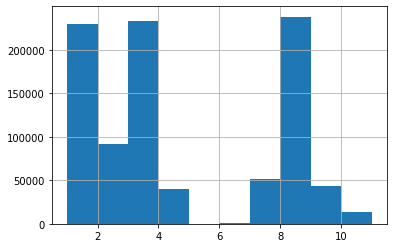

In [6]:
event_types = events.iloc[:,5]
event_types.hist()

Now analysing the shots, we can observe that the majority of the shots missed, and therefore we have an imbalanced dataset.

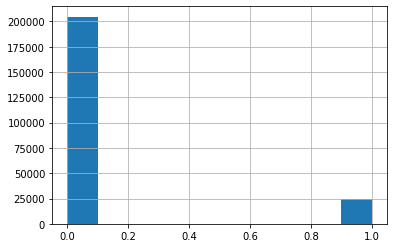

In [7]:
shots = events[(events.event_type==1)]

shots['is_goal'].hist()

# 3. Approach

In [8]:
#Useful imports
import pandas as pd
import numpy as np
import matplotlib as plt
from matplotlib import pyplot
import scipy as sp
import seaborn as sb
import sklearn
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,mean_squared_error, mean_absolute_error
from sklearn.metrics import cohen_kappa_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In our model we want to predict the number of goals by a team in a match, therefore, the depedent variable is the number of goals by a team.

As our independent variables we will supply:

* side - if a team is playing at home or not
* xG - the sum of all the shots odds of going in 
* shot_count - number of shots
* corner_count - number of corners
* yellow_card_count - yellow card count
* second_yellow_card_count - second yellow card count
* red_car_count - red card count
* free_kick_count - free kick count
* offside_count - offside count
* team tags - hash identifiers for the teams involved.

We added xG to prevent the lost of information by only adding the amount of shots, since every shot has a diferent probability of going in, depending on the shot location, part of the body and other.  xG corresponds to the added goal probability of every shot and, therefore, gives a rought estimate of the final score. However since we using a Neural network to calculate this probabilities there is an associated error to this, which we will try to mitigate.




## 3.1. Preparing the data

### 3.1.1 The xG Classifier
We use this classifier to obtain the probabilities values for each shot to go in.

In [9]:
shots = events[(events.event_type==1)]
shots_prediction = shots.iloc[:,-6:]
dummies = pd.get_dummies(shots_prediction, columns=['location', 'bodypart','assist_method', 'situation'])
dummies.columns = ['is_goal', 'fast_break', 'loc_centre_box', 'loc_diff_angle_lr', 'diff_angle_left', 'diff_angle_right', 'left_side_box', 'left_side_6ybox', 'right_side_box', 'right_side_6ybox', 'close_range', 'penalty', 'outside_box', 'long_range', 'more_35y', 'more_40y', 'not_recorded', 'right_foot', 'left_foot', 'header', 'no_assist', 'assist_pass', 'assist_cross', 'assist_header', 'assist_through_ball', 'open_play', 'set_piece', 'corner', 'free_kick']

In [10]:
X = dummies.iloc[:,1:]
y = dummies.iloc[:,0]

In [11]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=1)
mlp = MLPClassifier(random_state=0, hidden_layer_sizes=(28, 28, 28, 28), max_iter=2000, activation='relu')
mlp.fit(X_train, y_train)

CPU times: user 27.3 s, sys: 15.9 ms, total: 27.4 s
Wall time: 27.5 s


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(28, 28, 28, 28), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=2000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [12]:
predict = mlp.predict(X_test)
print('Confusion Matrix:')
print(confusion_matrix(y_test,predict))
print('Report:')
print(classification_report(y_test,predict))
accuracy = mlp.score(X_test, y_test)
print('The accuracy of classifying whether a shot is goal or not is {:.2f} %.'.format(accuracy*100))

Confusion Matrix:
[[70771   923]
 [ 6214  2290]]
Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     71694
           1       0.71      0.27      0.39      8504

    accuracy                           0.91     80198
   macro avg       0.82      0.63      0.67     80198
weighted avg       0.90      0.91      0.89     80198

The accuracy of classifying whether a shot is goal or not is 91.10 %.


### 3.1.2. Analysing the xG classifier

As noticed from the report above the performance for detecting positives is lower than the perfomance when detecting negatives. This is due to the unbalanced dataset which has way more misses then goals.
This might cause some errors which will lead to a more pessimistic estimation of the xG value and, therefore, worst final results.

### 3.1.3. Assembling everything

First we replace some categorical variables for binary dummies

In [13]:
dummies['xG'] = mlp.predict_proba(X)[:,1]
dummies = dummies[['xG']].copy()
dataWithXG = shots.join(dummies[['xG']])
matchXG = dataWithXG.groupby(['id_odsp', 'side'])['xG'].sum().reset_index()

Then we count every event in every match and then we join everything.

In [14]:
# Number of shots
attempts = events[(events.event_type==1)]
shotsSorted = attempts.groupby(['id_odsp', 'side']).count().reset_index()
shotsClean = shotsSorted[['id_odsp', 'side', 'id_event']].rename(columns={"id_event":"shot_count"})

# Number of corners
corners = events[(events.event_type==2)]
cornersSorted = corners.groupby(['id_odsp', 'side']).count().reset_index()
cornersClean = cornersSorted[['id_odsp', 'side', 'id_event']].rename(columns={"id_event":"corner_count"})

# Number of fouls
fouls = events[(events.event_type==3)]
foulsSorted = fouls.groupby(['id_odsp', 'side']).count().reset_index()
foulsClean = foulsSorted[['id_odsp', 'side', 'id_event']].rename(columns={"id_event":"foul_count"})

# Number of yellow cards
yellow_cards = events[(events.event_type==4)]
ycSorted = yellow_cards.groupby(['id_odsp', 'side']).count().reset_index()
ycClean = ycSorted[['id_odsp', 'side', 'id_event']].rename(columns={"id_event":"yellow_card_count"})

# Number of second yellow cards
second_yellow_cards= events[(events.event_type==5)]
sycSorted = second_yellow_cards.groupby(['id_odsp', 'side']).count().reset_index()
sycClean = sycSorted[['id_odsp', 'side', 'id_event']].rename(columns={"id_event":"second_yellow_card_count"})

# Number of red cards
red_cards = events[(events.event_type==6)]
redCardsSorted = red_cards.groupby(['id_odsp', 'side']).count().reset_index()
redCardsClean = redCardsSorted[['id_odsp', 'side', 'id_event']].rename(columns={"id_event":"red_card_count"})

# Number of freekicks
free_kicks = events[(events.event_type==8)]
fkSorted = free_kicks.groupby(['id_odsp', 'side']).count().reset_index()
fkClean = fkSorted[['id_odsp', 'side', 'id_event']].rename(columns={"id_event":"free_kick_count"})

# Number of offsides
offsides = events[(events.event_type==9)].copy()
offsidesSorted = offsides.groupby(['id_odsp', 'side']).count().reset_index()
offsidesClean = offsidesSorted[['id_odsp', 'side', 'id_event']].rename(columns={"id_event":"offside_count"})



In [15]:
#Joins results
joinColumns = ['id_odsp', 'side']

fullDataset = matchXG

fullDataset = fullDataset.merge(shotsClean, on=joinColumns, how='left') 
fullDataset = fullDataset.merge(cornersClean, on=joinColumns, how='left') 
fullDataset = fullDataset.merge(ycClean, on=joinColumns, how='left') 
fullDataset = fullDataset.merge(sycClean, on=joinColumns, how='left') 
fullDataset = fullDataset.merge(redCardsClean, on=joinColumns, how='left') 
fullDataset = fullDataset.merge(fkClean, on=joinColumns, how='left') 
fullDataset = fullDataset.merge(offsidesClean, on=joinColumns, how='left') 
fullDataset= fullDataset.merge(events[['id_odsp', 'side', 'event_team']].drop_duplicates(), on=joinColumns, how='left')
fullDataset = fullDataset.fillna(0)

for column in fullDataset.columns:
    if column.endswith('_count'):
        fullDataset[column] = fullDataset[column].astype(int)

        
        

In [16]:
homeGoals = games[['id_odsp', 'fthg']].rename(columns={'fthg':'goals'})
homeGoals.insert(2, 'side', 1)
awayGoals = games[['id_odsp', 'ftag']].rename(columns={'ftag':'goals'})
awayGoals.insert(2, 'side', 2)
totalGoals = homeGoals.append(awayGoals)
fullDataset = fullDataset.merge(totalGoals, on=joinColumns, how='left')

In [17]:
fullDataset['other_side'] = fullDataset['side'].apply(lambda x: 2 if x == 1 else 1)

In [18]:
teamNames = fullDataset[['id_odsp', 'event_team', 'side']].rename(columns={'event_team':'other_event_team', 'side':'other_side'})
fullDataset = fullDataset.merge(teamNames, on=['id_odsp', 'other_side'], how='left').drop(columns=['other_side'])

In the end we obtain something like this:

In [19]:
fullDataset.head()

,id_odsp,side,xG,shot_count,corner_count,yellow_card_count,second_yellow_card_count,red_card_count,free_kick_count,offside_count,event_team,goals,other_event_team
0,004f4ING/,1,1.413347,15,9,1,0,1,8,0,Southampton,0,Swansea
1,004f4ING/,2,0.453106,6,0,1,0,0,10,3,Swansea,1,Southampton
2,00LMl81F/,1,2.949324,24,13,2,0,0,14,0,AS Roma,2,AC Milan
3,00LMl81F/,2,1.608309,15,4,3,0,1,10,6,AC Milan,3,AS Roma
4,00OX4xFp/,1,1.166929,9,4,1,0,0,18,3,AS Monaco,0,Lille


## 3.2 Models
Firstly, remove from some columns only used to merge tables together and then we procede to split the data into the X and y variables

In [20]:
fullDataset['event_team'] = fullDataset['event_team'].apply(hash)
fullDataset['other_event_team'] = fullDataset['other_event_team'].apply(hash)
colunas = list(fullDataset.columns)
colunas.remove('goals')
colunas.remove('id_odsp')
fullX = fullDataset[colunas]
fullY = fullDataset[['goals']].values.ravel()

In [21]:
from itertools import combinations
columnList = []
for i in range(len(fullX.columns)):
    columnList.extend( map(lambda x: list(x), sorted(list(combinations(fullX.columns, i+1))))    ) 

### Finder Function

The finder function, explores each attribute effect on the models by testing all possible combinations of the features in the models training.

In [22]:
def finder(model):
    results = []
    for i,entry in enumerate(columnList):
        print(f'\rTrying for {i} out of {len(columnList)-1}', end='')
        fullXTrain, fullXTest, fullYTrain, fullYTest = train_test_split(fullX[entry], fullY, test_size=0.35, random_state=1)
        model.fit(fullXTrain, fullYTrain)
        results.append((model.score(fullXTest, fullYTest), entry))
    results.sort(reverse=True)
    results

In [23]:
model_results = []
# for calculating F2 adjusted
def adjusted_r2(r2, mod):
    return (1 - (1 - r2) * ((mod.shape[0] - 1) / 
          (mod.shape[0] - mod.shape[1] - 1)))

### 3.2.1 Models without Team Names
For this first models we won't consider the teams playing the game, which are represented by the hashes.

#### 3.2.1.1 Decision Tree

In [24]:
fullXTrain, fullXTest, fullYTrain, fullYTest = train_test_split(fullX.drop(columns=['event_team', 'other_event_team']), fullY, test_size=0.35, random_state=1)
decTree = tree.DecisionTreeRegressor(max_depth=5)

In [25]:
%%time
decTree.fit(fullXTrain, fullYTrain)

CPU times: user 36.6 ms, sys: 0 ns, total: 36.6 ms
Wall time: 36 ms


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [26]:
%%time
r2 = decTree.score(fullXTest, fullYTest)

CPU times: user 4.25 ms, sys: 0 ns, total: 4.25 ms
Wall time: 3.79 ms


In [27]:
predict = decTree.predict(fullXTest)
absErr = mean_absolute_error(fullYTest,predict)
sqErr = mean_squared_error(fullYTest,predict)
adjR2 = adjusted_r2(r2, fullXTest)

print(f'r2={r2} adjR2={adjR2} adjR2={absErr} sqErr={sqErr}')
model_results.append(['Decision Tree', r2, adjR2, absErr, sqErr])

r2=0.351361636870826 adjR2=0.35044100207061113 adjR2=0.7758382314746908 sqErr=0.9947996472626568


#### 3.2.1.2 Random Forest

In [28]:
fullXTrain, fullXTest, fullYTrain, fullYTest = train_test_split(fullX.drop(columns=['event_team', 'other_event_team']), fullY, test_size=0.35, random_state=1)
randForest = RandomForestRegressor(max_depth=5)

In [29]:
%%time
randForest.fit(fullXTrain, fullYTrain)

CPU times: user 1.17 s, sys: 0 ns, total: 1.17 s
Wall time: 1.18 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [30]:
%%time
r2 = randForest.score(fullXTest, fullYTest)

CPU times: user 31.3 ms, sys: 0 ns, total: 31.3 ms
Wall time: 31.2 ms


In [31]:
predict = randForest.predict(fullXTest)
absErr = mean_absolute_error(fullYTest,predict)
sqErr = mean_squared_error(fullYTest,predict)
adjR2 = adjusted_r2(r2, fullXTest)

print(f'r2={r2} adjR2={adjR2} adjR2={absErr} sqErr={sqErr}')
model_results.append(['Random Forest', r2, adjR2, absErr, sqErr])

r2=0.37505762631716033 adjR2=0.37417062405203727 adjR2=0.765296311331233 sqErr=0.9584577296661814


#### 3.2.1.3 Support vector machine

In [32]:
from sklearn import svm
fullXTrain, fullXTest, fullYTrain, fullYTest = train_test_split(fullX.drop(columns=['other_event_team','event_team']), fullY, test_size=0.35, random_state=1)
svm = svm.LinearSVR(max_iter=40000)

In [33]:
%%time
svm.fit(fullXTrain, fullYTrain)

CPU times: user 2.84 s, sys: 0 ns, total: 2.84 s
Wall time: 2.85 s


LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=40000,
          random_state=None, tol=0.0001, verbose=0)

In [34]:
%%time
r2 = svm.score(fullXTest, fullYTest)

CPU times: user 720 µs, sys: 6.75 ms, total: 7.47 ms
Wall time: 1.94 ms


In [35]:
predict = svm.predict(fullXTest)
absErr = mean_absolute_error(fullYTest,predict)
sqErr = mean_squared_error(fullYTest,predict)
adjR2 = adjusted_r2(r2, fullXTest)

print(f'r2={r2} adjR2={adjR2} adjR2={absErr} sqErr={sqErr}')
model_results.append(['Linear SVR', r2, adjR2, absErr, sqErr])

r2=0.364881338474108 adjR2=0.36397989265267083 adjR2=0.7560058264581454 sqErr=0.9740648354621976


#### 3.2.1.4 Neural Network (Multiple layer perceptron)

In [36]:
fullXTrain, fullXTest, fullYTrain, fullYTest = train_test_split(fullX.drop(columns=['other_event_team','event_team']), fullY, test_size=0.35, random_state=1)
mlpReg = MLPRegressor()

In [37]:
%%time
mlpReg.fit(fullXTrain, fullYTrain)

CPU times: user 27.5 s, sys: 27 s, total: 54.5 s
Wall time: 7.55 s


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [38]:
%%time
r2 = mlpReg.score(fullXTest, fullYTest)

CPU times: user 34.8 ms, sys: 21.3 ms, total: 56.1 ms
Wall time: 9.1 ms


In [39]:
predict = mlpReg.predict(fullXTest)
absErr = mean_absolute_error(fullYTest,predict)
sqErr = mean_squared_error(fullYTest,predict)
adjR2 = adjusted_r2(r2, fullXTest)

print(f'r2={r2} adjR2={adjR2} adjR2={absErr} sqErr={sqErr}')
model_results.append(['MLP', r2, adjR2, absErr, sqErr])

r2=0.3834992954407287 adjR2=0.3826242747277444 adjR2=0.7590447706593783 sqErr=0.9455109631105907


#### 3.2.1.5 Metrics comparisons
We use as indicators: R², MAE, MSE and adjusted R²

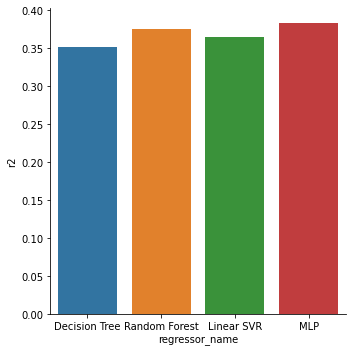

In [40]:
results = pd.DataFrame(model_results, columns=['regressor_name', 'r2', 'adjR2', 'absErr', 'sqErr'])
sb.catplot(x='regressor_name', y='r2', kind='bar',data=results)

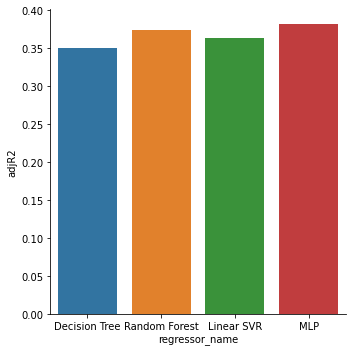

In [41]:

sb.catplot(x='regressor_name', y='adjR2', kind='bar',data=results)

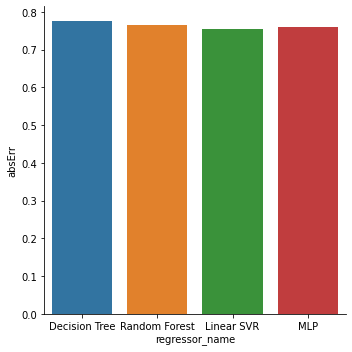

In [42]:
sb.catplot(x='regressor_name', y='absErr', kind='bar',data=results)

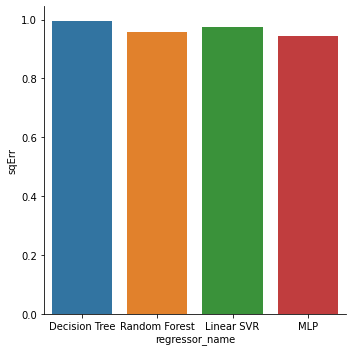

In [43]:
sb.catplot(x='regressor_name', y='sqErr', kind='bar',data=results)

From the graphs we can conclude that MLP is the one that adjusts best to our data. Howerver r² is still a low value and the values for MAE and MRE are high in all the models.

### 3.2.2 Team Name Effects
In this section we have in mind the team's hashes.

In [44]:
model_results.clear()

#### 3.2.2.1 Decision Tree

In [45]:
fullXTrain, fullXTest, fullYTrain, fullYTest = train_test_split(fullX, fullY, test_size=0.35, random_state=1)
decTree = tree.DecisionTreeRegressor(max_depth=5)

In [46]:
%%time
decTree.fit(fullXTrain, fullYTrain)

CPU times: user 43.7 ms, sys: 0 ns, total: 43.7 ms
Wall time: 43.2 ms


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [47]:
%%time
r2 = decTree.score(fullXTest, fullYTest)

CPU times: user 4.15 ms, sys: 67 µs, total: 4.22 ms
Wall time: 3.74 ms


In [48]:
predict = decTree.predict(fullXTest)
absErr = mean_absolute_error(fullYTest,predict)
sqErr = mean_squared_error(fullYTest,predict)
adjR2 = adjusted_r2(r2, fullXTest)

print(f'r2={r2} adjR2={adjR2} adjR2={absErr} sqErr={sqErr}')
model_results.append(['Decision Tree', r2, adjR2, absErr, sqErr])

r2=0.35410069525310783 adjR2=0.3529798729858393 adjR2=0.7757749526210574 sqErr=0.9905988252524064


#### 3.2.1.2 Random Forest

In [49]:
fullXTrain, fullXTest, fullYTrain, fullYTest = train_test_split(fullX, fullY, test_size=0.35, random_state=1)
randForest = RandomForestRegressor(max_depth=5)

In [50]:
%%time
randForest.fit(fullXTrain, fullYTrain)

CPU times: user 1.5 s, sys: 4.21 ms, total: 1.51 s
Wall time: 1.51 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [51]:
%%time
r2 = randForest.score(fullXTest, fullYTest)

CPU times: user 33.5 ms, sys: 0 ns, total: 33.5 ms
Wall time: 33.5 ms


In [52]:
predict = randForest.predict(fullXTest)
absErr = mean_absolute_error(fullYTest,predict)
sqErr = mean_squared_error(fullYTest,predict)
adjR2 = adjusted_r2(r2, fullXTest)

print(f'r2={r2} adjR2={adjR2} adjR2={absErr} sqErr={sqErr}')
model_results.append(['Random Forest', r2, adjR2, absErr, sqErr])

r2=0.3750989284022709 adjR2=0.37401454414803925 adjR2=0.7655210672772503 sqErr=0.9583943857413771


#### 3.2.1.3 Support vector machine

In [53]:
from sklearn import svm
fullXTrain, fullXTest, fullYTrain, fullYTest = train_test_split(fullX, fullY, test_size=0.35, random_state=1)
svm = svm.LinearSVR(max_iter=40000)

In [54]:
%%time
svm.fit(fullXTrain, fullYTrain)

CPU times: user 30.2 s, sys: 4.47 ms, total: 30.2 s
Wall time: 30.2 s


/home/paulo/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=40000,
          random_state=None, tol=0.0001, verbose=0)

In [55]:
%%time
r2 = svm.score(fullXTest, fullYTest)

CPU times: user 13.4 ms, sys: 38.9 ms, total: 52.4 ms
Wall time: 10.8 ms


In [56]:
predict = svm.predict(fullXTest)
absErr = mean_absolute_error(fullYTest,predict)
sqErr = mean_squared_error(fullYTest,predict)
adjR2 = adjusted_r2(r2, fullXTest)

print(f'r2={r2} adjR2={adjR2} adjR2={absErr} sqErr={sqErr}')
model_results.append(['Linear SVR', r2, adjR2, absErr, sqErr])

r2=-1.2011501908147681 adjR2=-1.2049698235800248 adjR2=1.3572665721933554 sqErr=3.3758463234136356


#### 3.2.1.4 Neural Network (Multiple layer perceptron)

In [57]:
fullXTrain, fullXTest, fullYTrain, fullYTest = train_test_split(fullX, fullY, test_size=0.35, random_state=1)
mlpReg = MLPRegressor()

In [58]:
%%time
mlpReg.fit(fullXTrain, fullYTrain)

CPU times: user 44.8 s, sys: 44 s, total: 1min 28s
Wall time: 12.8 s


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [59]:
%%time
r2 = mlpReg.score(fullXTest, fullYTest)

CPU times: user 66.1 ms, sys: 73 ms, total: 139 ms
Wall time: 22.2 ms


In [60]:
predict = mlpReg.predict(fullXTest)
absErr = mean_absolute_error(fullYTest,predict)
sqErr = mean_squared_error(fullYTest,predict)
adjR2 = adjusted_r2(r2, fullXTest)

print(f'r2={r2} adjR2={adjR2} adjR2={absErr} sqErr={sqErr}')
model_results.append(['MLP', r2, adjR2, absErr, sqErr])

r2=-3.4726652158922356e+29 adjR2=-3.4786912953014186e+29 adjR2=486264516999205.44 sqErr=5.325935572427623e+29


#### 3.2.1.5 Metrics comparisons
We use as indicators: R², MAE, MSE and adjusted R²

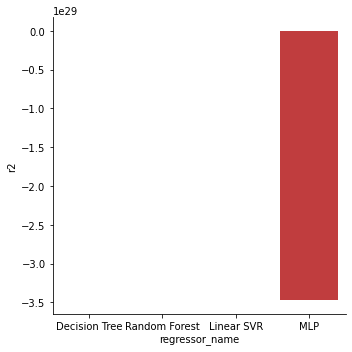

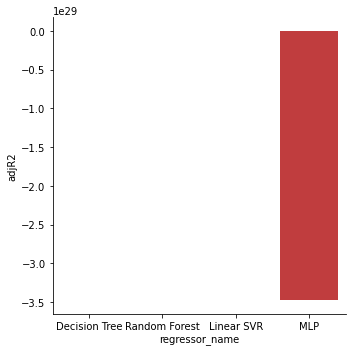

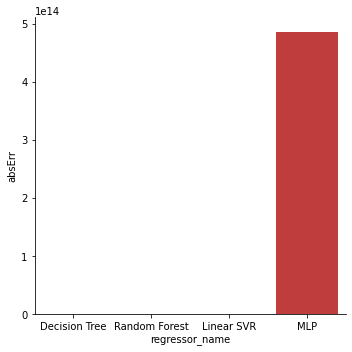

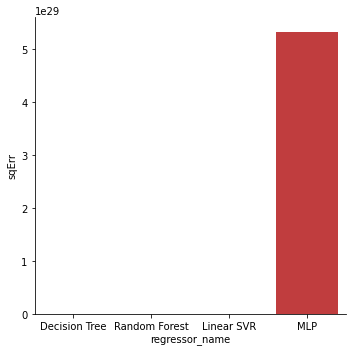

In [61]:
results = pd.DataFrame(model_results, columns=['regressor_name', 'r2', 'adjR2', 'absErr', 'sqErr'])
sb.catplot(x='regressor_name', y='r2', kind='bar',data=results)
sb.catplot(x='regressor_name', y='adjR2', kind='bar',data=results)
sb.catplot(x='regressor_name', y='absErr', kind='bar',data=results)
sb.catplot(x='regressor_name', y='sqErr', kind='bar',data=results)

Since the MLP metrics are away off the charts, we will exclude it on the following graphs.

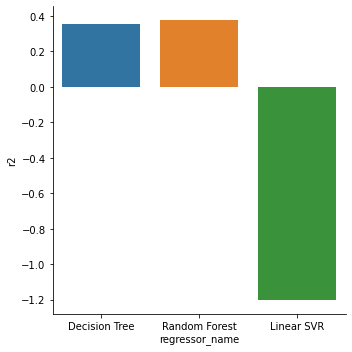

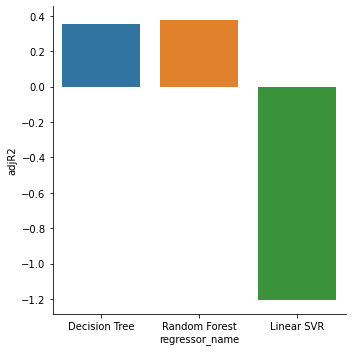

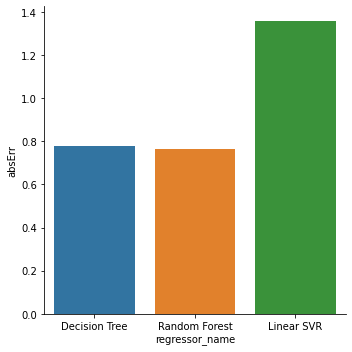

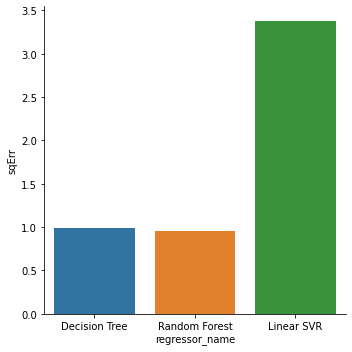

In [62]:
results = pd.DataFrame(filter(lambda x: x[0] != 'MLP', model_results), columns=['regressor_name', 'r2', 'adjR2', 'absErr', 'sqErr'])
sb.catplot(x='regressor_name', y='r2', kind='bar',data=results)
sb.catplot(x='regressor_name', y='adjR2', kind='bar',data=results)
sb.catplot(x='regressor_name', y='absErr', kind='bar',data=results)
sb.catplot(x='regressor_name', y='sqErr', kind='bar',data=results)


As we can observer neither Linear SVR or MLP deal well with the team hashes. Howerver, decision trees based algorithms seem to handle this quite well, even though the error metrics are still high.

# 4. Evaluation

## 4.1 Decision Tree Based Models

### 4.1.2  Advantages
Compared to other models decisions trees showed almost no change when including both team names, these parameters showing up in deeper levels of the trees, which implies the model was able to recognize some teams. The problem is the lack of versatality, since the decisions are based on lower/bigger than comparisons then if a new team is introduced the model wouldn't be able to capture it correctly.


### 4.1.3 Disadvantges

Although they can model very well the dataset, it was verified that they're less flexible in terms of newer incoming data.

## 4.2 SVM and MLP Models

### 4.2.1 Advantages

These models capture some nuances about the dataset, thus they can be more versatile and deal better with newer incoming data.

### 4.2.2 Disadvantages

These models deal terribly with categorical data, team names, making the result not adapted at all to the dataset. By removing the team names they started to get results that matched the decision tree based models. Thus when working these kinds of models it's highly important to do feature analysis and understand which ones are driving the decisions.

### 4.3 Team Names - Feature analysis

At first it was thought that including the team names was crucial to calculate the number of goals. Decision trees showed promising results but the MLP and SVM Models were severally lacking in this component, showing a negative adaptation to the data.

By removing these fields it can be seen that it the models that were performing well and the ones that were having trouble modeling, improved by a landslide their results. This implies that the models are already taking into consideration the teams, by implicitly extrapolating through the features (namely xG).

# 5. Conclusions



Football matches are inherently non-determistic and its outcomes can't predicted simply by looking at happend in the field.

The errors in our models could appear very large (which they are), however it is worth remembering that there exists a high number of outliers, such as a very high number of goals, something that is nearly never predicted by the model, which tends to be more conservative.
Besides, number of goals which a team scores doesn't depend only on the recorded statistics, it also depends on player health, team state of mind, factors that are foreign to the games like club internal conflicts, that are not captured in this dataset.
An example of a situation not captured, are the "bad days" of the athletes, where they are statistically regular but their shots are not scoring.
Outlier detection gets harder, due to not existing a baseline to go off width.



To finalize, the dataset while containing some key events of the match also fails to capture other statistics such as ball possession that is fundamental to determine who's controlling the match.

### References